In [21]:
# 📘 train_yolov8_medical.ipynb

# 🛠️ Step 1: Install and Import Dependencies
!pip install ultralytics --quiet

import os
import random
import shutil
from pathlib import Path
import yaml
import torch
from ultralytics import YOLO

In [22]:
# 📁 Step 2: Define Paths
BASE_DIR = Path("/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products")
IMAGES_DIR = BASE_DIR / 'images'
LABELS_DIR = BASE_DIR / 'labels'
CLASS_FILE = BASE_DIR / 'classes.txt'

# Create YOLO-compatible directory structure
yolo_base = BASE_DIR / 'yolo_dataset'
(TRAIN_IMG := yolo_base / 'images' / 'train').mkdir(parents=True, exist_ok=True)
(VAL_IMG := yolo_base / 'images' / 'val').mkdir(parents=True, exist_ok=True)
(TRAIN_LBL := yolo_base / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
(VAL_LBL := yolo_base / 'labels' / 'val').mkdir(parents=True, exist_ok=True)

In [23]:
# 🔀 Step 3: Split Dataset into Train/Val
all_images = list(IMAGES_DIR.glob("*.jpg")) + list(IMAGES_DIR.glob("*.png"))
random.seed(42)
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

def copy_data(image_list, img_dst, lbl_dst):
    for img_path in image_list:
        label_path = LABELS_DIR / f"{img_path.stem}.txt"
        if label_path.exists():
            shutil.copy(img_path, img_dst / img_path.name)
            shutil.copy(label_path, lbl_dst / label_path.name)

copy_data(train_images, TRAIN_IMG, TRAIN_LBL)
copy_data(val_images, VAL_IMG, VAL_LBL)

In [24]:
# 🧾 Step 4: Create dataset.yaml
with open(CLASS_FILE, 'r', encoding='utf-8') as f:
    class_names = [line.strip() for line in f.readlines()]

dataset_yaml = {
    'path': str(yolo_base.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(class_names),
    'names': class_names
}

yaml_path = yolo_base / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_yaml, f)

print(f"✅ dataset.yaml created at {yaml_path}")

✅ dataset.yaml created at /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/dataset.yaml


In [25]:
from pathlib import Path

train_img_dir = Path("/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train")
label_img_dir = Path("/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/labels/train")

print("🖼️ Image files:", list(train_img_dir.glob("*.jpg")) + list(train_img_dir.glob("*.png")))
print("🏷️ Label files:", list(label_img_dir.glob("*.txt")))


🖼️ Image files: [PosixPath('/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train/a1b38bdd-Medical-Devices-Medicine_CovLibrary-MD-1000px.jpg'), PosixPath('/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train/7e24f628-61Q6CfbvPsL.jpg'), PosixPath('/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train/2a70558c-LATEX_GLOVES_PAIR__17754.jpg'), PosixPath('/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train/423dcc56-2022100919075mg.jpg'), PosixPath('/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/images/train/097b845b-66a0108fd75bb5e0bce58db2_Nitrile-Glove_Thumbna

In [27]:
# 🚀 Step 5: Monkey Patch torch.load to avoid weights_only issue (PyTorch 2.6+)
import torch
original_load = torch.load

def patched_torch_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return original_load(*args, **kwargs)

torch.load = patched_torch_load  # Apply patch

# Load model
model = YOLO("yolov8n.pt")

# Train model (everything inside stays under patch)
results = model.train(
    data=str(yaml_path),
    epochs=50,
    imgsz=640,
    batch=16,
    name='yolov8n-medical-products',
    workers=4
)

torch.load = original_load  # ✅ Restore after training


New https://pypi.org/project/ultralytics/8.3.166 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.28 🚀 Python-3.12.11 torch-2.7.1 CPU (Apple M4 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n-medical-products3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fal

train: Scanning /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/labels/train.cache... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<?, ?it/s]
/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/labels/val.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]


Plotting labels to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
       1/50         0G      1.116      3.595      1.341         20        640: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all          2          2    0.00926          1      0.253      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.395      3.561       1.63         19        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

                   all          2          2    0.00905          1      0.253      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
       3/50         0G      1.091      3.557      1.361         25        640: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all          2          2    0.00905          1      0.253      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/50         0G     0.9775      3.576      1.362         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]

                   all          2          2    0.00873          1      0.253      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.258      3.573      1.438         33        640: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all          2          2    0.00862          1       0.17      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
       6/50         0G      1.088       3.65      1.348         21        640: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all          2          2    0.00835          1       0.17      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G     0.8526      3.431      1.189         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all          2          2    0.00838          1      0.253      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50         0G      1.359       3.69      1.445         46        640: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all          2          2    0.00874          1      0.258        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.158      3.293      1.444         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.37it/s]

                   all          2          2    0.00892          1      0.506      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      10/50         0G      1.087      3.456      1.247         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all          2          2    0.00897          1      0.258      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50         0G      1.104      3.264      1.334         30        640: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all          2          2    0.00863          1      0.257      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      12/50         0G     0.9684      3.282      1.328         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all          2          2    0.00884          1      0.257      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G       1.14      3.335      1.401         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all          2          2    0.00891          1      0.256      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.014       3.12      1.324         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

                   all          2          2    0.00874          1      0.257      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/50         0G     0.8384       3.09      1.209         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]

                   all          2          2    0.00891          1      0.256      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      16/50         0G      0.798      3.211       1.14         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all          2          2    0.00866          1      0.255      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G     0.9121      2.819        1.2         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all          2          2     0.0086          1      0.256      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9703      2.889      1.171         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all          2          2     0.0086          1      0.256      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      19/50         0G     0.8267      2.771      1.095         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all          2          2     0.0087          1      0.256      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.8692      2.787      1.072         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all          2          2     0.0087          1      0.256      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.8443      2.779      1.093         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]

                   all          2          2    0.00823          1      0.256      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/50         0G     0.9485      2.712      1.282         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all          2          2    0.00823          1      0.256      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      23/50         0G     0.9515      2.436      1.075         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          2          2    0.00819          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.9103       2.58      1.171         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all          2          2    0.00819          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      25/50         0G     0.9625      2.517      1.142         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all          2          2    0.00823          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50         0G     0.8042      2.516      1.085         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all          2          2    0.00823          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9221      2.393      1.178         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all          2          2    0.00812          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      28/50         0G     0.7281      2.504       1.13         17        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all          2          2    0.00812          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9759      2.072      1.227         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all          2          2    0.00803          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G     0.8952      1.983      1.063         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all          2          2    0.00803          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9648      2.417      1.139         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.81it/s]

                   all          2          2      0.008          1      0.257      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9192      2.416      1.273         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all          2          2      0.008          1      0.257      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      33/50         0G     0.8029      1.904      1.094         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.16it/s]

                   all          2          2    0.00793          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G     0.8583       2.33      1.145         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all          2          2    0.00793          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.9357      1.935      1.165         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all          2          2    0.00808          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.5682      1.848      1.038         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all          2          2    0.00808          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      37/50         0G     0.7778      2.191      1.085         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all          2          2    0.00828          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.8468      2.407      1.216         26        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all          2          2    0.00828          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      39/50         0G     0.8077       2.19      1.135         20        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]

                   all          2          2    0.00872          1      0.256      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50         0G     0.7948      1.919      1.047         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all          2          2    0.00872          1      0.256      0.204
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
      41/50         0G     0.8993      1.797       1.07         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all          2          2    0.00868          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      42/50         0G     0.6191      1.981      1.029         13        640: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all          2          2    0.00868          1      0.256      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.7094      1.865      1.086         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all          2          2    0.00894          1      0.257      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      44/50         0G     0.5612      1.634      1.028         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all          2          2    0.00894          1      0.257      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.7041      1.661      1.023         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]

                   all          2          2    0.00898          1      0.258      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.5922      1.448     0.9541         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all          2          2    0.00898          1      0.258      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6721      1.722      1.003         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.56it/s]

                   all          2          2    0.00922          1      0.259      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      48/50         0G     0.6708      1.699      1.096         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all          2          2    0.00922          1      0.259      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G     0.6764      1.595      1.062         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all          2          2    0.00903          1      0.261      0.207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



  0%|          | 0/1 [00:00<?, ?it/s]libpng warning: iCCP: known incorrect sRGB profile
      50/50         0G     0.7382       1.85      1.097         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.94it/s]

                   all          2          2    0.00903          1      0.261      0.207



50 epochs completed in 0.015 hours.
Optimizer stripped from /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/last.pt, 6.2MB
Optimizer stripped from /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/best.pt, 6.2MB

Validating /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/best.pt...
Ultralytics YOLOv8.1.28 🚀 Python-3.12.11 torch-2.7.1 CPU (Apple M4 Pro)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


                   all          2          2     0.0087          1      0.506      0.401
        medicine_strip          2          1    0.00676          1     0.0175    0.00524
              oximeter          2          1     0.0106          1      0.995      0.796
Speed: 0.8ms preprocess, 33.1ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3


In [28]:
# 📊 Step 6: Evaluate Model
metrics = model.val()
print(f"📈 mAP50: {metrics.box.map50:.4f}")
print(f"📈 mAP50-95: {metrics.box.map:.4f}")

Ultralytics YOLOv8.1.28 🚀 Python-3.12.11 torch-2.7.1 CPU (Apple M4 Pro)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/yolo_dataset/labels/val.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]
/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


                   all          2          2     0.0087          1      0.506      0.401
        medicine_strip          2          1    0.00676          1     0.0175    0.00524
              oximeter          2          1     0.0106          1      0.995      0.796
Speed: 3.3ms preprocess, 53.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products32
📈 mAP50: 0.5062
📈 mAP50-95: 0.4006



image 1/1 /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/data/raw/labeled_medical_products/images/b8f41852-GettyImages-1292318009-91773f45006a4cb7a75a785f412519bb.jpg: 448x640 (no detections), 69.6ms
Speed: 4.9ms preprocess, 69.6ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products34


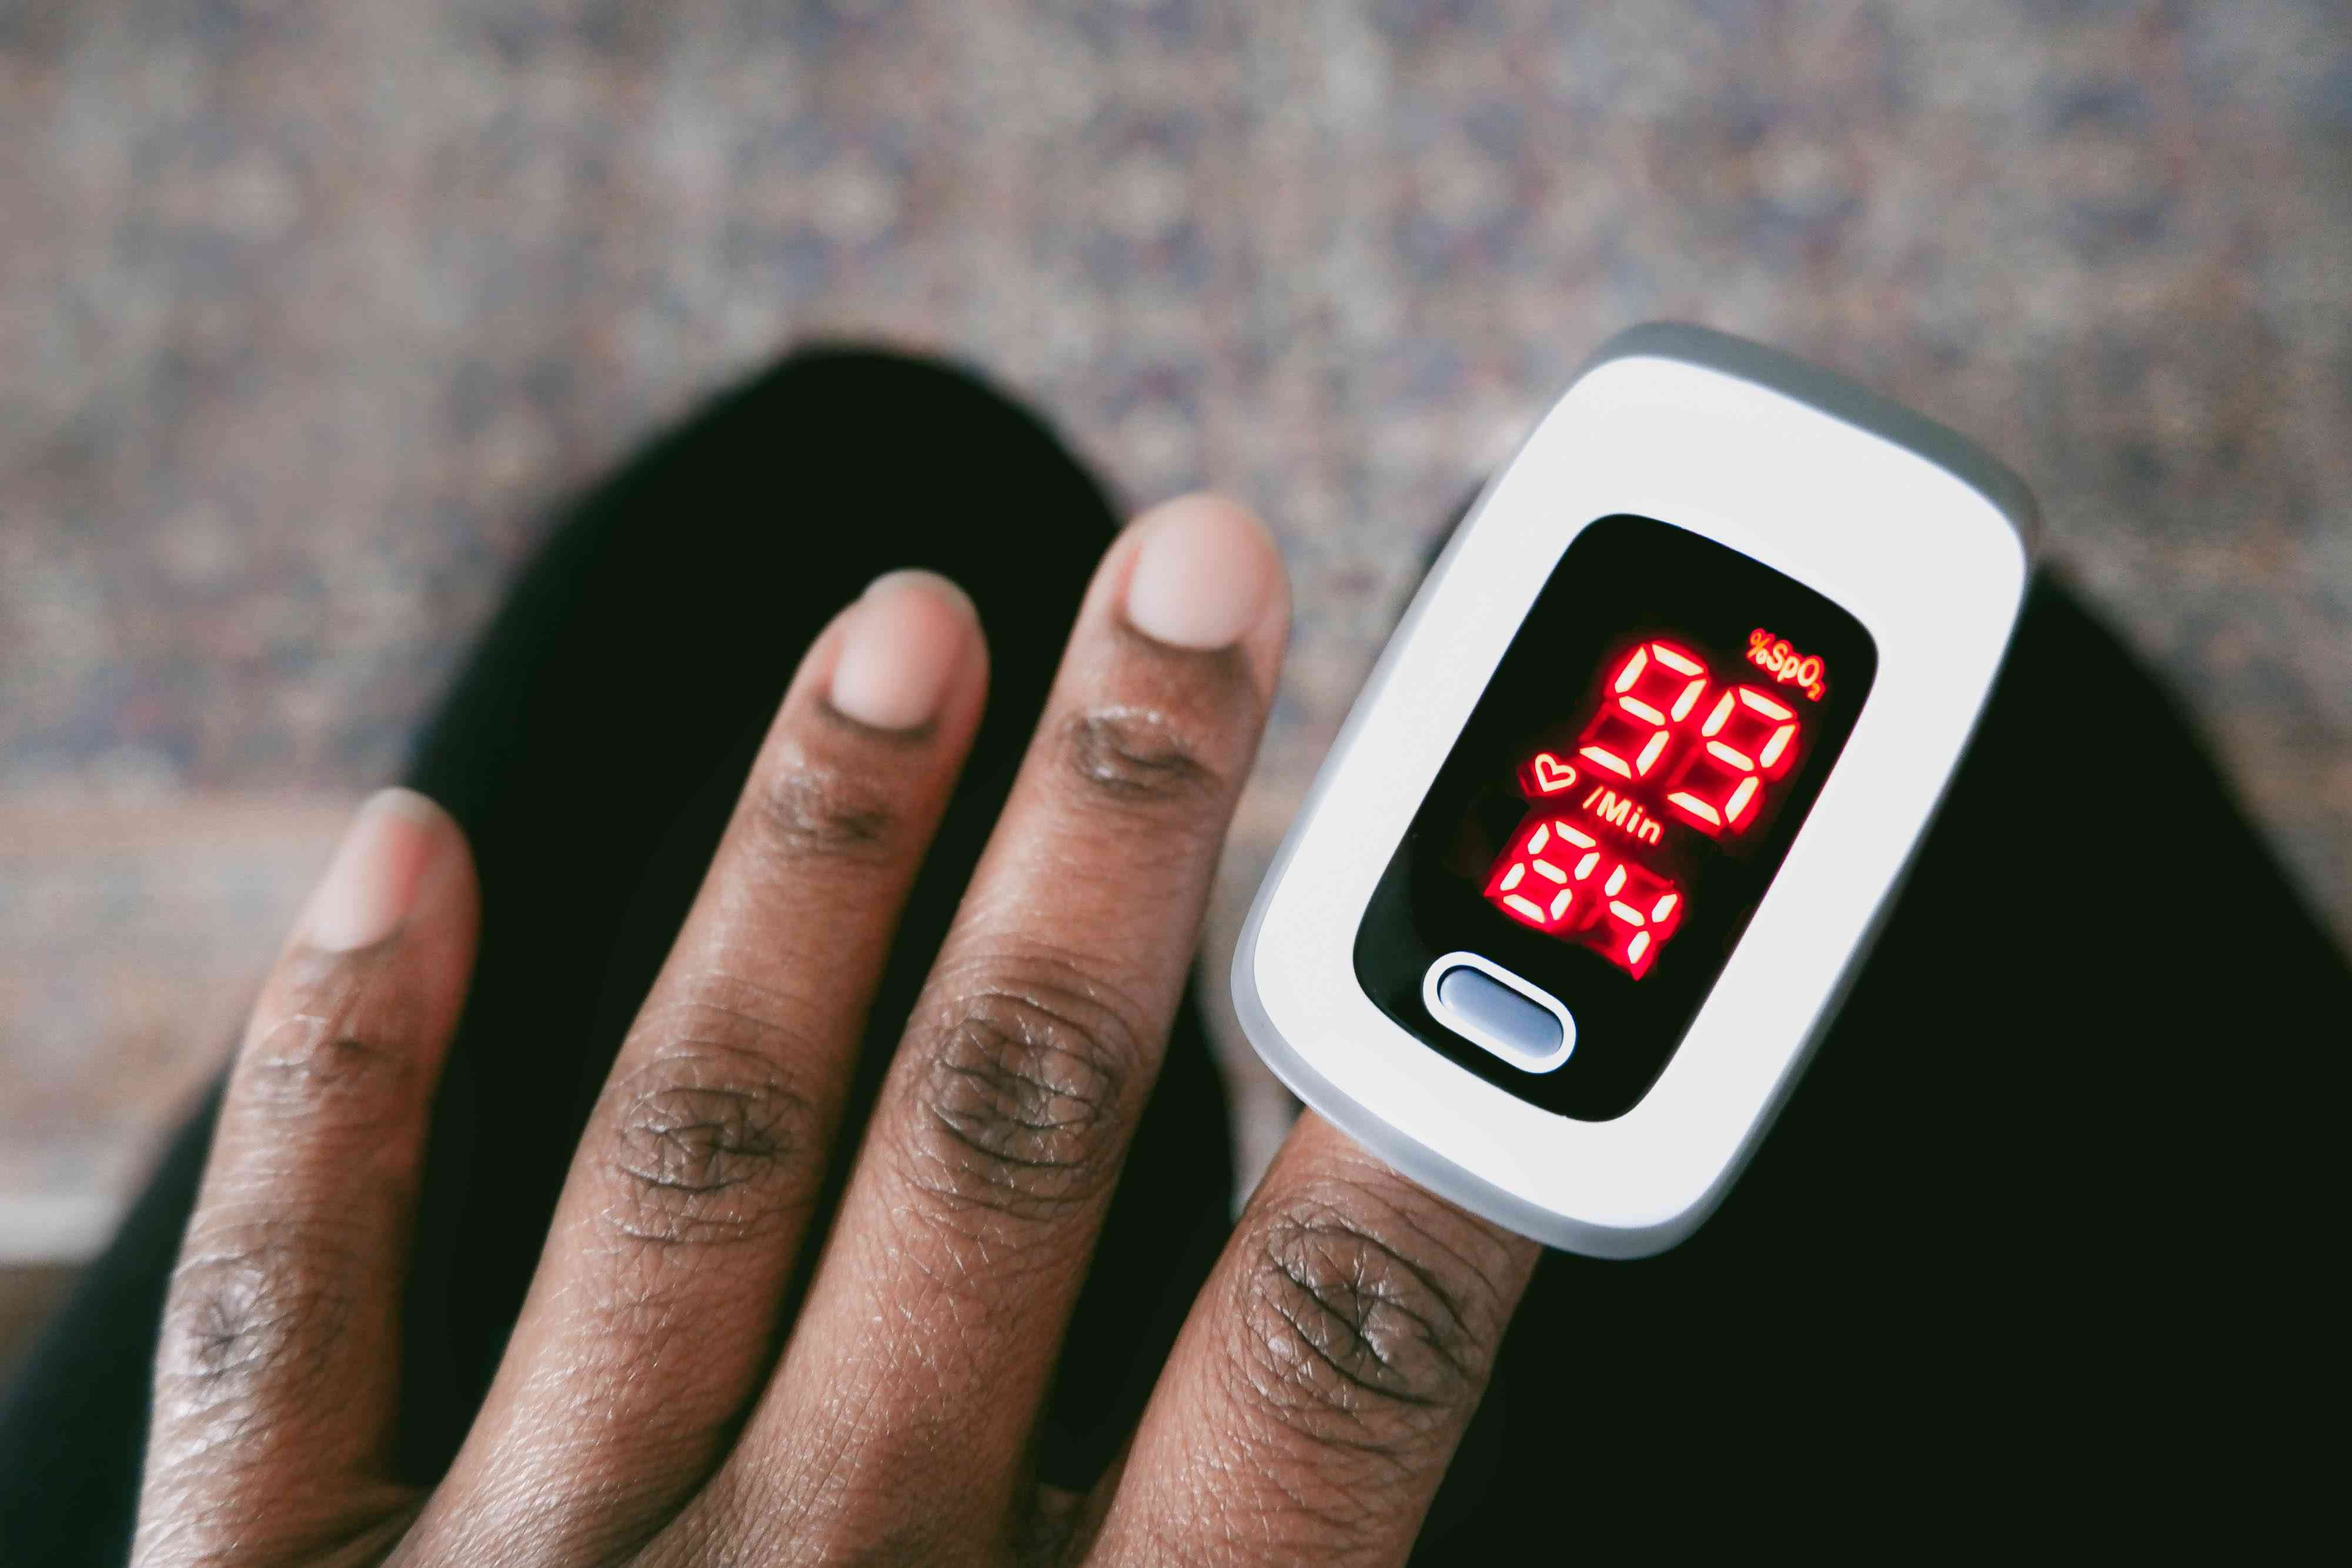

In [30]:
# 🔍 Step 7: Predict on Sample Image
from pathlib import Path
from IPython.display import Image, display

sample_image = str(val_images[0])
results = model.predict(source=sample_image, save=True, conf=0.25)

# ✅ Correct: convert save_dir to Path before using `/`
output_path = Path(results[0].save_dir) / Path(sample_image).name
display(Image(filename=output_path))

In [31]:
# 📦 Step 8: Export Model (Optional)
model.export(format="onnx")

Ultralytics YOLOv8.1.28 🚀 Python-3.12.11 torch-2.7.1 CPU (Apple M4 Pro)

PyTorch: starting from '/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 595.0 kB/s eta 0:00:00a 0:00:01

requirements: AutoUpdate success ✅ 42.3s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.18.0 opset 19...
ONNX: export success ✅ 44.3s, saved as '/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/best.onnx' (11.7 MB)

Export complete (44.6s)
Results saved to /Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-t

'/Users/mikiyasegaye/MK_Lab/10 Academy/From-Raw-Telegram-Data-to-an-Analytical-API/runs/detect/yolov8n-medical-products3/weights/best.onnx'